# Latent Dirichlet Allocation

This is the main chunk of the code.

The eventual goal is to treat the hashtag list for each user as being document1, and the cleaned full-text words as being document 2. So each user has two documents. Now I do topic modeling across each document for each user and for each user find a list of topics, and then the words that lie within each topic. Therefore, I have now for each user a dictionary with keys as topics and values as the words associated with each topic. What I am then hoping to do is some sort of visualization to extract the most relevant topics that exhibit the words that I am interested in. 

In [17]:
# General imports
import json
import glob
import pickle
import collections
import random
from tqdm import tqdm as tqdm
import config
import time
import os
dirpath = os.path.dirname(os.path.realpath('__file__'))
from pprint import pprint

# import logging
# logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
# logging.root.level = logging.INFO

# NLP imports
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'http', 'https', 'http'])
import re
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# To check later if a words is in english or not
with open('./words_dictionary.json') as filehandle:
    words_dictionary = json.load(filehandle)
english_words = words_dictionary.keys()

# Visualization imports
import pyLDAvis
import pyLDAvis.gensim
# pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt

# Other imports
import pandas as pd
import numpy as np
import tweepy

## Creating the cleaned and simplified tweet dictionary

Here, we first load in the dictionaries that were dumped in as pickle files and then do a series of text processing and cleaning tasks. I initially start with a dicitonary of the form:

```
{
    market_1: {
                screen_name_1: [{tweet1, ..., tweetn}],
                .
                .
                .
                screen_name_m: [{tweet1, ..., tweetn}]
             }
    .
    .
    .
    market_k: {
                screen_name_1: [{tweet1, ..., tweetn}],
                .
                .
                .
                screen_name_m: [{tweet1, ..., tweetn}]
             }
}
```

This section of the code will then process will result in a dictionary of the form

```
{
    market_1: {
                screen_name_1: 
                    {
                        hashtags: [list of hashtags from each tweet], 
                        fulltext: [list of all cleaned/depunkt words across all tweets]
                    },
                .
                .
                screen_name_m: 
                    {
                        hashtags: [list of hashtags from each tweet], 
                        fulltext: [list of all cleaned/depunkt words across all tweets]
                    }
              }
    .
    .
    .
    market_k: {
                screen_name_1: 
                    {
                        hashtags: [list of hashtags from each tweet], 
                        fulltext: [list of all cleaned/depunkt words across all tweets]
                    },
                .
                .
                screen_name_m: 
                    {
                        hashtags: [list of hashtags from each tweet], 
                        fulltext: [list of all cleaned/depunkt words across all tweets]
                    }
              }
}
```

Then I can turn this into a pandas dataframe and do some pretty nice data manipulation.

We will call this dictionary the `master_dict`.

To do this, we first define some helper functions

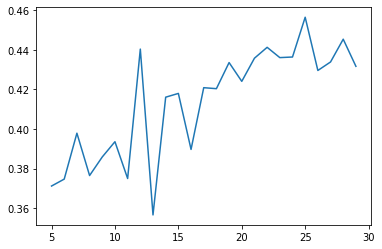

In [6]:
k = range(5, 30)
coherence_scores = ([.3712, .3747, .3979, .3765, .3859, .3936, 
                     .3750, .4404, .3566, .4161, .4180, .3897, 
                     .4209, .4204, .4336, .4241, .4358, .4413, 
                     .4361, .4364, .4565, .4296, .4339, .4454, .4317])
plt.plot(k, coherence_scores)

In [7]:
def get_user(tweet):
    """
    input: tweet dictionary
    returns: return the username
    """
    return tweet['user']['screen_name']


def get_hashtag_list(tweet):
    """
    input: tweet dictionary
    returns: list of all hashtags in both the direct tweet and the
    retweet 
    """

    l = []
    for d in tweet['entities']['hashtags']:
        l += [d['text']]

    if 'retweeted_status' in tweet.keys():
        for d in tweet['retweeted_status']['entities']['hashtags']:
            l += [d['text']]
    return l


def tokenizer_cleaner_nostop_lemmatizer(text):
    """
    This function tokenizes the text of a tweet, cleans it off punctuation,
    removes stop words, and lemmatizes the words (i.e. finds word roots to remove noise)
    I am largely using the gensim and spacy packages 

    Input: Some text
    Output: List of tokenized, cleaned, lemmatized words
    """

    tokenized_depunkt = gensim.utils.simple_preprocess(text, min_len=4, deacc=True)
    tokenized_depunkt_nostop = ([word for word in tokenized_depunkt 
                                 if word not in stop_words and word in english_words])
    
    # Lemmatizer while also only allowing certain parts of speech.
    # See here: https://spacy.io/api/annotation
    allowed_pos = ['ADJ', 'ADV', 'NOUN', 'PROPN','VERB']
    doc = nlp(' '.join(tokenized_depunkt_nostop))
    words_final = [token.lemma_ for token in doc if token.pos_ in allowed_pos]
    return words_final

    
def get_tweet_words_list(tweet):
    """
    This function takes in a tweet and checks if there is a retweet associated with it
    input: tweet
    output: list of tokenized words without punctuation
    """

    text = tweet['full_text']
    clean_words = tokenizer_cleaner_nostop_lemmatizer(text)
    
    if 'retweeted_status' in tweet.keys():
        retweet_text = tweet['retweeted_status']['full_text']
        retweet_clean_words = tokenizer_cleaner_nostop_lemmatizer(retweet_text)
        clean_words += retweet_clean_words
    return clean_words

In [8]:
# with open('./data/all_tweets_dict.data', 'rb') as filehandle:
#     all_tweets_data = pickle.load(filehandle)

# master_dict = {}

# for market in all_tweets_data:
#     followers = all_tweets_data[market]
#     master_dict[market] = {}

#     for follower in tqdm(followers):
#         tweets = all_tweets_data[market][follower] # list of tweet_.json
#         master_dict[market][follower] = {}
#         master_dict[market][follower]['hashtags'] = []
#         master_dict[market][follower]['fulltext'] = []
#         for tweet in tweets:
#             hashtags = get_hashtag_list(tweet)
#             words = get_tweet_words_list(tweet)
            
#             master_dict[market][follower]['hashtags'].extend(hashtags)
#             master_dict[market][follower]['fulltext'].extend(words)

# with open('./data/master_dict.data', 'wb') as filehandle:
#     pickle.dump(master_dict, filehandle, protocol=pickle.HIGHEST_PROTOCOL)

## Latent Dirichlet Allocation

Now we apply the LDA algorithm to identify themes in the documents/topics. In my case, a single document corresponds to the set of all words of a single user's tweets. Note that the list of words that comprose a document have already been cleaned, tokenized and lemmatized. 

One other thought is to have one MASSIVE document containing all tweets of all users, and then finding the topics there. In the comparison step, I could use these top topics and then compare this to all tweets of individual users and then returning top-k users based on similarity. See [this](https://stats.stackexchange.com/questions/269031/how-to-find-similar-documents-after-a-latent-dirichlet-allocation-model-is-bui) stack-exchange post for ideas.

We first write some helper functions

In [9]:
with open('./data/master_dict.data', 'rb') as filehandle:
    master_dict = pickle.load(filehandle)

In [10]:
def get_docs(d, market):
    """
    Accepts a market and then returns the documents for the market. A document
    is a list of of word lists for each user in the market city i.e. it is a list of lists.
    Each outer list is a follower and the innner list is the cleaner, tokenized, depunkt, 
    lematized set of words for that follower.
    """
    docs = []
    for user in tqdm(d[market]):
        text_list = d[market][user]['fulltext']
        docs.append(text_list)
    return docs

In [21]:
markets = list(master_dict.keys())
docs = get_docs(master_dict, markets[1])
id2word = corpora.Dictionary(docs)
corpus = [id2word.doc2bow(doc) for doc in docs]

# Maybe at this point, remove words that appear only once or twice in the corpus

100%|████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:00<?, ?it/s]


In [22]:
def compute_lda(corpus, id2word, k=22, alpha='auto'):
    """
    Performs the LDA and returns the computer model.
    Input: Corpus, dictionary and hyperparameters to optimize
    Output: the fitted/computed LDA model
    """
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, 
                                                id2word=id2word,
                                                num_topics=k,
                                                random_state=100,
                                                # update_every=1,
                                                chunksize=5,
                                                passes=50,
                                                alpha=.01,
                                                per_word_topics=True)
    return lda_model

lda_model = compute_lda(corpus, id2word)
t2 = time.time()
lda_model.save('./lda_model/lda_model_market1.model')
pprint(lda_model.print_topics())


C:\Users\adity\AppData\Local\Continuum\anaconda3\envs\insightenv\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\adity\AppData\Local\Continuum\anaconda3\envs\insightenv\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[(19,
  '0.045*"photography" + 0.007*"trump" + 0.006*"make" + 0.004*"park" + '
  '0.004*"sunset" + 0.004*"lake" + 0.004*"may" + 0.004*"national" + '
  '0.004*"aurora" + 0.003*"dwell"'),
 (16,
  '0.055*"abortion" + 0.046*"portland" + 0.024*"woman" + 0.023*"fertility" + '
  '0.014*"acupuncture" + 0.013*"health" + 0.013*"access" + 0.012*"help" + '
  '0.012*"care" + 0.009*"pregnancy"'),
 (8,
  '0.008*"make" + 0.007*"work" + 0.007*"time" + 0.006*"know" + '
  '0.006*"entrepreneur" + 0.006*"great" + 0.006*"good" + 0.006*"take" + '
  '0.005*"thank" + 0.005*"people"'),
 (6,
  '0.059*"check" + 0.028*"vintage" + 0.010*"handmade" + 0.010*"gift" + '
  '0.008*"baby" + 0.007*"disney" + 0.006*"shop" + 0.006*"woman" + 0.005*"rare" '
  '+ 0.005*"glass"'),
 (11,
  '0.020*"coffee" + 0.013*"table" + 0.011*"auction" + 0.010*"cover" + '
  '0.009*"year" + 0.007*"woman" + 0.007*"today" + 0.007*"housing" + '
  '0.006*"register" + 0.006*"look"'),
 (12,
  '0.110*"market" + 0.067*"farmer" + 0.030*"today" + 0.026*"

### Some comments on the hyperparameter tuning:

1. Doing a chunksize of 1 is pretty slow and time consuming (although it might be worthwhile to time this more accurately). I think either choosing `chunksize=5` or `chunksize=10` works well.
2. `passes` is a parameter similar to number of epochs. 
3. `alpha='auto'` seems to work pretty well. 
4. Keep `random_state=100` in case you want to repeat results. 
5. Keep `update_every` small, ideally equal to 1. 
6. Use a for loop to calculate the optimal number of topics. This just has to be done. Might be better to do this in the background on the python terminal

## Calculating the Coherence score

In [16]:
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=docs,
                                     dictionary=id2word,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score:', coherence_lda)


Coherence Score: 0.4577590844248159


In [ ]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word, mds='tsne')
pyLDAvis.show(LDAvis_prepared)